# Intro to Bayesian Statistics

This presentation is a very quick introduction to the application of Bayesian Statistics for A/B testing for conversion rate.  If you're interested to learn more, I suggest reading:

* Bayesian Analysis with Python - Osvaldo Martin
* Statistical Rethinking - Richard McElreath
* [Bayesian Modeling and Computation in Python](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368) - Osvaldo A. Martin, Ravin Kumar, Junpeng Lao 

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pymc as pm
import arviz as az
import numpy
import pymc
import pandas as pd

sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("poster", font_scale=0.75)
sns.set_style("whitegrid")
%config InlineBackend.figure_format='retina'

np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}%".format(x)})

## Agenda
1. Bayesian Updating Intuition
2. Intro to Bayesian Formula
    * Bayes with point probabilities
    * There's so much more than point probabilities
3. Jumping into it with PyMC4 and ArviZ
4. Breaking things apart
    * Priors
    * Likelihood
    * Probabalistic Programming Languages (PPLs)
    * The Magic Inference Button 
    * Posterior plots
3. Turning intuition into statistics using PyMC4 and ArviZ

## Intro to Bayes Formula in a hurry
$$
\Large
p(\theta \mid y) = \frac{ p(y \mid \theta)p(\theta)}{p(y)}
$$

The idea of updating beliefs based on new data is captured in Bayes Formula:
* The prior $p(\theta)$ which describes the belief in the world before seeing new data  
* The likelihood $p(y \mid \theta)$ which describes the probability of the "parameter" given the data  
* The posterior $ p(\theta \mid y)$ which is the updated belief after seeing the data
* The base rate $ p(y) $ which is the probability of the thing happening. This term is difficult or impossible to ascertain in many situations so Modern Bayesian approaches utilize mathematical tricks to avoid calculating this.

### The Math
This formula is derived from a rearranging of terms for joint probabilities:

$$
P(\theta, y) = P(\theta)P(y | \theta) = P(y)P(\theta | y)
$$

## Example with randomly generated data

We want to know the effectiveness of our treatment in our app, business or processes. A treatment can be any type of change that you hope to improve the business in some way which include workflow, website, algorithm changes and more.  Conversion rate is your defined metric of success.  This includes lead generation, engagement rate, click rate, customer call rate, etc.  It is worthy to note that a reduction in conversion rate is sometimes preferable such as a customer call rate; you want customers to call for support less often with your change.

Here, we define our hypothesis:

&emsp; $H_{0}$: With the treatment, there is no change in conversion rate

&emsp; $H_{1}$: With the treatment, we see an increase in conversion rate by 5% 

### 1. Read data

The indicator is 1 if there is a conversion and 0 otherwise.

In [2]:
conversion_control = pd.read_csv('../data/conversion_rate_control_period.csv', names=['has_converted'])
conversion_control = conversion_control['has_converted'].to_numpy()

conversion_control[0:20]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [3]:
conversion_test = pd.read_csv('../data/conversion_rate_test_period.csv', names=['has_converted'])
conversion_test = conversion_test['has_converted'].to_numpy()

conversion_test[0:20]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1])

Here we compute the conversion probability. The `mean` on binary data gives us the percentage of ones.

In [4]:
print("Control: n_trail %d and n_conversion %d" % (len(conversion_control), sum(conversion_control)))
print("        Conversion%% (A): %5.2f%%\n" % (np.mean(conversion_control)*100.0))

print("Test : n_trail %d and n_conversion %d" % (len(conversion_test), sum(conversion_test)))
print("        Conversion%% (B): %5.2f%%" % (np.mean(conversion_test)*100.0))

Control: n_trail 166 and n_conversion 55
        Conversion% (A): 33.13%

Test : n_trail 440 and n_conversion 175
        Conversion% (B): 39.77%


### 2. Assign to variables typically used in PyMC

* conversion_a is the control group which is the data set without improvement labeled as __a__.
* conversions_b is the treatment group which is the data set with the improvement labeled as __b__.

In [5]:
# Initialize variables
conversions_a = conversion_control
conversions_b = conversion_test

seed = 88888
conversion_test_threshold = 0.35

## Build conversion rate model & Bernoulli Likelihood Function

Next, we use pymc (4.0) and build our conversion rate model feeding in conversion data (version A) before treatment was introduced.

On how to pick the representative distribution as your likelihood function, check out:

&emsp; Distribution Explorer https://distribution-explorer.github.io

In [6]:
# Our PRIOR BELIEF: Before Treatment => Conversion A
with pm.Model():
    
    # parameter we want to infer with PRIOR
    conversion_rate_prior_a = pm.Beta("conversion_rate_a", 3, 10)
    
    # likelihood of observing data given parameter
    likelihood = pm.Bernoulli("likelihood", 
                              p=conversion_rate_prior_a, 
                              observed=conversions_a)
    
    # Prior Predictive BEFORE seeing the observations
    prior_predictive_a = pm.sample_prior_predictive(samples=10000, random_seed=seed)
    
    # Hit the magical inference button
    idata_a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [7]:
def plot_side_by_side(BETA_alpha, BETA_beta, prior_predictive):

    sns.set(rc={'figure.figsize':(16, 5)})
    sns.set_context("poster", font_scale=0.75)
    sns.set_style("whitegrid")
    
    # call regplot on each axes
    fig, ax = plt.subplots(1, 2, figsize=(20,6), sharex=True)

    ax[0] = plt.subplot(1,2,1)
    x1 = np.linspace(0, 1, 100)
    ax[0].plot(x1, sps.beta(BETA_alpha, BETA_beta).pdf(x1), label="Beta (%d, %d)"%(BETA_alpha, BETA_beta))
    ax[0].set_xlabel("Conversion rate a")
    ax[0].set_ylabel("Prior Belief")
    ax[0].set_xlim(0, 1)
    ax[0].set_title("Belief *before* seeing data")
    ax[0].legend()
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax[1] = plt.subplot(1,2,2)
    ax[1] = sns.histplot(prior_predictive, label="Draws from Prior Distribution")
    ax[1].set_xlabel("Conversion rate a")
    ax[1].set_ylabel("Plausible value count")
    ax[1].set_title("Prior Predictive")
    ax[1].legend()
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.show()

In [8]:
prior_pred_a = prior_predictive_a.prior.stack(draws=("chain", "draw"))["conversion_rate_a"].values

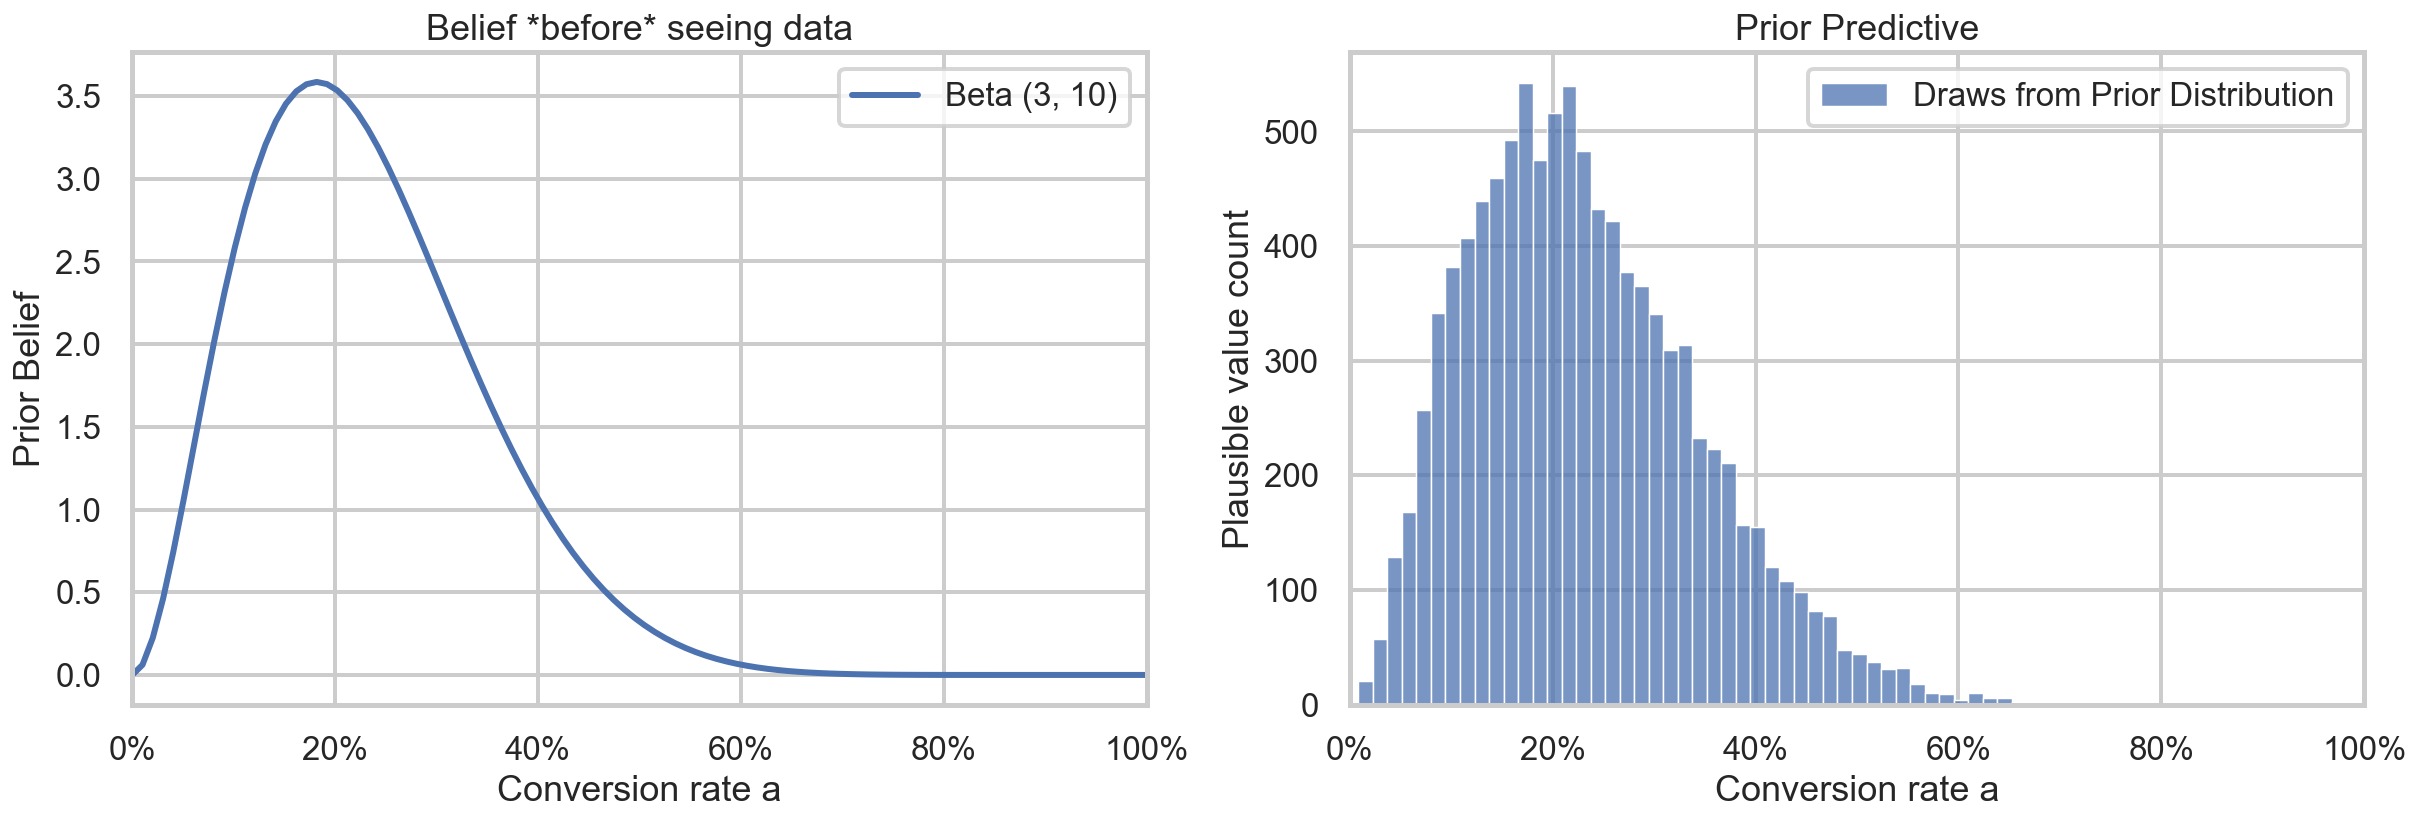

In [9]:
plot_side_by_side(3, 10, prior_pred_a)

In [10]:
# Inferenced on Prior

post_conversion_a = idata_a.posterior.stack(draws=("chain", "draw"))["conversion_rate_a"].values
np.round(100 * post_conversion_a, 2)[:20]

array([27.9%, 35.6%, 34.0%, 29.9%, 29.9%, 33.9%, 26.2%, 29.9%, 31.2%,
       33.4%, 38.2%, 34.2%, 34.2%, 31.3%, 34.1%, 35.8%, 32.7%, 31.6%,
       33.9%, 34.0%])

### How plausible is it for the conversion rate at a certain level?

If we want to ask questions about our posterior, we can just slice into our posterior (after seeing the data) according to the question we want to ask (here, how plausible it is to have a conversion rate > 35%).

We generate a histogram of plausible values.

In [11]:
def plot_plausible(BETA_alpha, BETA_beta, plausible_a, conversion_test_threshold):
    sns.set(rc={'figure.figsize':(16, 5)})
    sns.set_context("poster", font_scale=0.75)
    sns.set_style("whitegrid")
    # call regplot on each axes
    fig, ax = plt.subplots(1, 2, figsize=(20,6), sharex=True)

    ax[0] = plt.subplot(1,2,1)
    x1 = np.linspace(0, 1, 100)
    ax[0].plot(x1, sps.beta(BETA_alpha, BETA_beta).pdf(x1), label="Beta (%d, %d)"%(BETA_alpha, BETA_beta))
    ax[0].set_xlabel("Conversion rate a")
    ax[0].set_ylabel("Prior Belief")
    ax[0].set_xlim(0, 1)
    ax[0].set_title("Belief *before* seeing data")
    ax[0].legend()
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax[1] = plt.subplot(1,2,2)
    ax[1] = sns.histplot(plausible_a[plausible_a < conversion_test_threshold], label="conv rate < %3.2f"%(conversion_test_threshold))
    sns.histplot(plausible_a[plausible_a > conversion_test_threshold], color="r", label="conv rate > %3.2f"%(conversion_test_threshold), ax=ax[1])
    ax[1].set_xlabel("Conversion rate a")
    ax[1].set_ylabel("Plausible value count")
    ax[1].axvline(conversion_test_threshold, color="k", ls="--")
    ax[1].set_title("Plausible solutions *after* seeing data")
    ax[1].legend()
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.show()

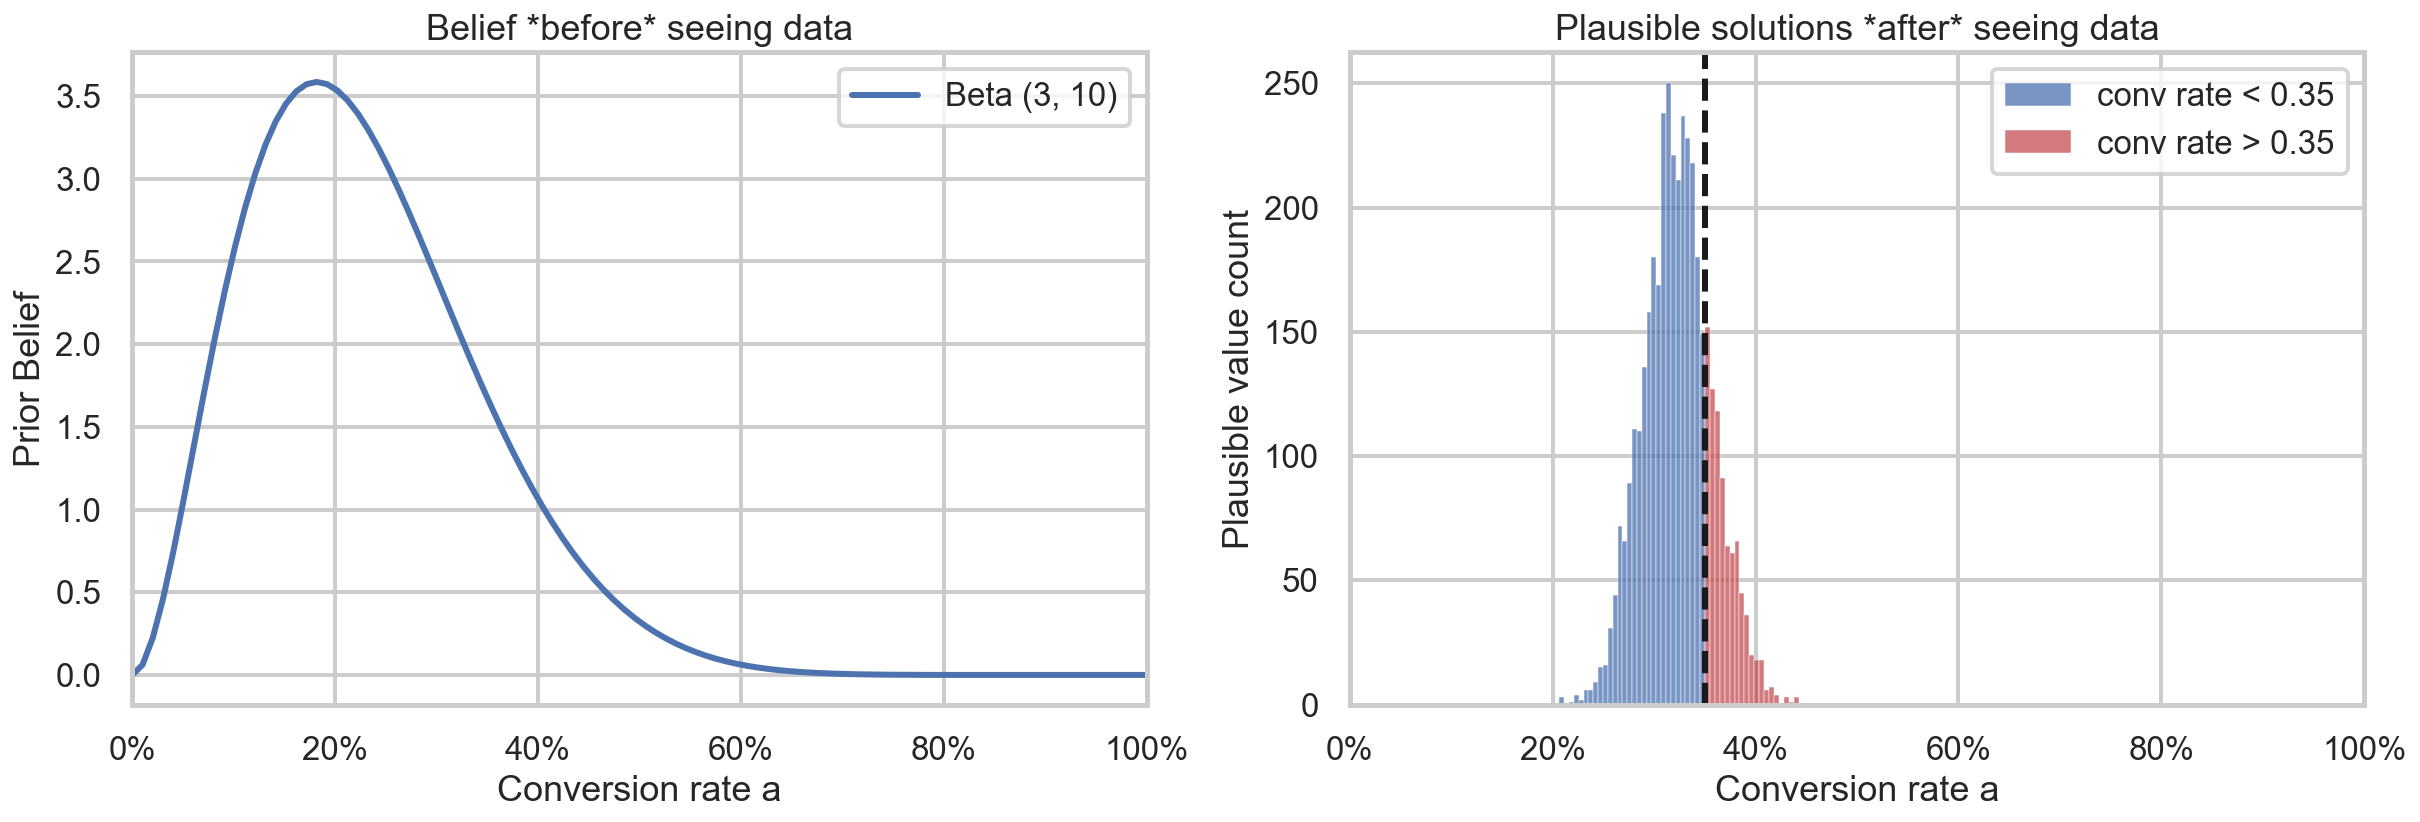

In [12]:
plot_plausible(3, 10, post_conversion_a, conversion_test_threshold)

### In Bayesian statistics - We count things!

If we want to know the chances in the control period the conversion rate is greater than 35%, we count the samples.

The mean gives us the probability, i.e. the proportion of plausible values for which the statement is true.

In [13]:
print(post_conversion_a < conversion_test_threshold)
print("probability that conversion rate: control < Test:", np.mean(post_conversion_a < conversion_test_threshold))
print("probability that conversion rate: control > Test:",np.mean(post_conversion_a > conversion_test_threshold))

[ True False  True ...  True  True  True]
probability that conversion rate: control < Test: 0.79
probability that conversion rate: control > Test: 0.21


In [14]:
def plot_hdi(hdi_data, hdi_level=0.94):
    sns.set(rc={'figure.figsize':(14, 8)})
    sns.set_context("poster", font_scale=0.75)
    sns.set_style("whitegrid")
    az.plot_posterior(hdi_data, hdi_prob=hdi_level)
    plt.show()

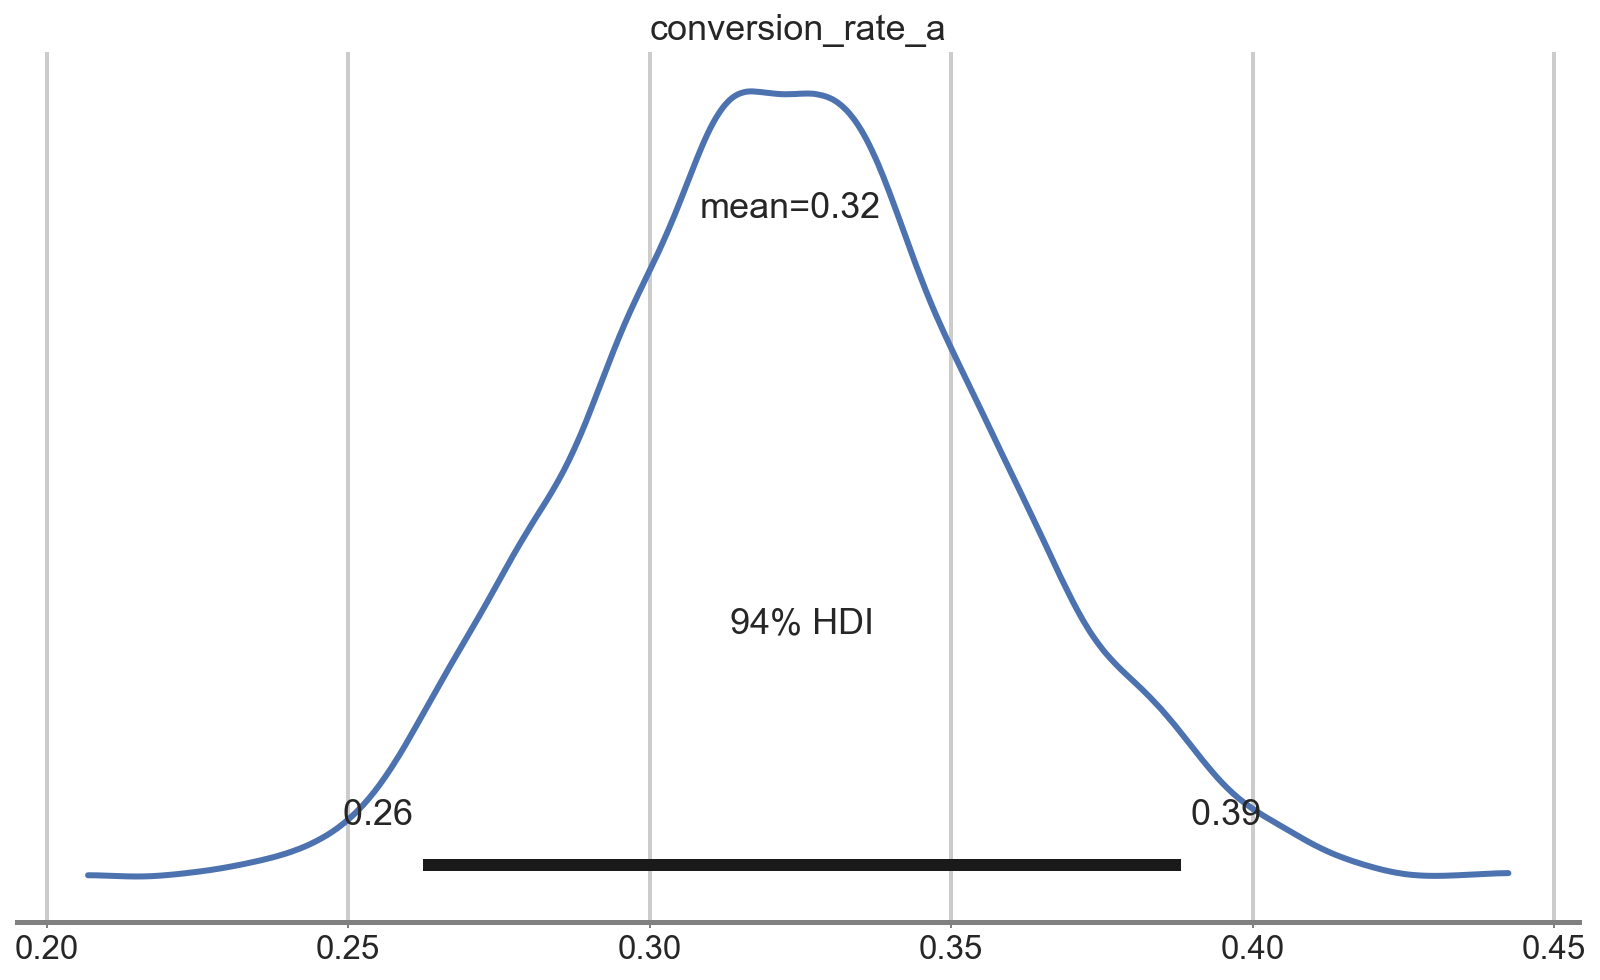

In [15]:
# Recall the magical inference button earlier

plot_hdi(idata_a)

## High Density Interval versus Confidence Interval

High Density Interval is different than Confidence Interval.

HDI is the credible interval in which 94% (or 95%) of the area under the curve representing the PDF (probability density function).

CI is a range of estimates for an unknown parameter where we assume it is represented by a given distribution and its relative mean, standard deviation, skewness or moments can be estimated.

## Steps to build a model for After Treatment was introduced

1. Build a model for estimating the conversiont rate after the treatment was implemented.
2. Extract the posterior of plausible values of the conversion rate.
3. Plot a histogram of plausible values for the converstion rate for control and test period.
4. Compute the probability that conversion for test period greater than the control period.

### Model Building & Bernoulli Likilhood Function

In [16]:
# AFTER treatment - Conversion rate => Conversion B
with pm.Model():
    
    # parameter we want to infer with PRIOR
    conversion_rate_b_prior = pm.Beta("conversion_rate_b", 3, 10)
    
    # likelihood of observing data given parameter
    how_likely = pm.Bernoulli("how_likely", 
                              p=conversion_rate_b_prior, 
                              observed=conversions_b)
    
    # Hit the magical inference button
    idata_b = pm.sample()

    
post_conversion_b = idata_b.posterior.stack(draws=("chain", "draw"))["conversion_rate_b"].values    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [17]:
def plot_rate_before_after(conv_before, conv_after):
    
    sns.set(rc={'figure.figsize':(14, 8)})
    sns.set_context("poster", font_scale=0.75)
    sns.set_style("whitegrid")
    
    # call regplot on each axes
    fig, ax = plt.subplots(1, 2, figsize=(20,6), sharex=True)
    
    ax[0] = plt.subplot(1,2,1)
    ax[0] = sns.histplot(conv_before, label="conv rate: control")
    sns.histplot(conv_after, label="conv rate: test", color="r", ax=ax[0])
    ax[0].legend()
    ax[0].set_xlabel("Conversion rate")
    ax[0].set_ylabel("Plausible value count")
    ax[1].set_title("Conv rate in control & test seeing the data")

    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax[1] = plt.subplot(1,2,2)
    ax[1] = sns.histplot(conv_before, label="conv rate: control", color="C0", alpha=.3)
    sns.histplot(conv_after, label="conv rate: test", color="C1", alpha=.3, ax=ax[1])
    sns.histplot(conv_before[conv_before > conv_after], 
                 label="conv rate before > conv rate after", color="C2", ax=ax[1])

    ax[1].legend()
    ax[1].set_xlabel("conversion rate")
    ax[1].set_ylabel("Plausible value count")
    ax[1].set_title("Probability of conv rate before > after seeing the data")

    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

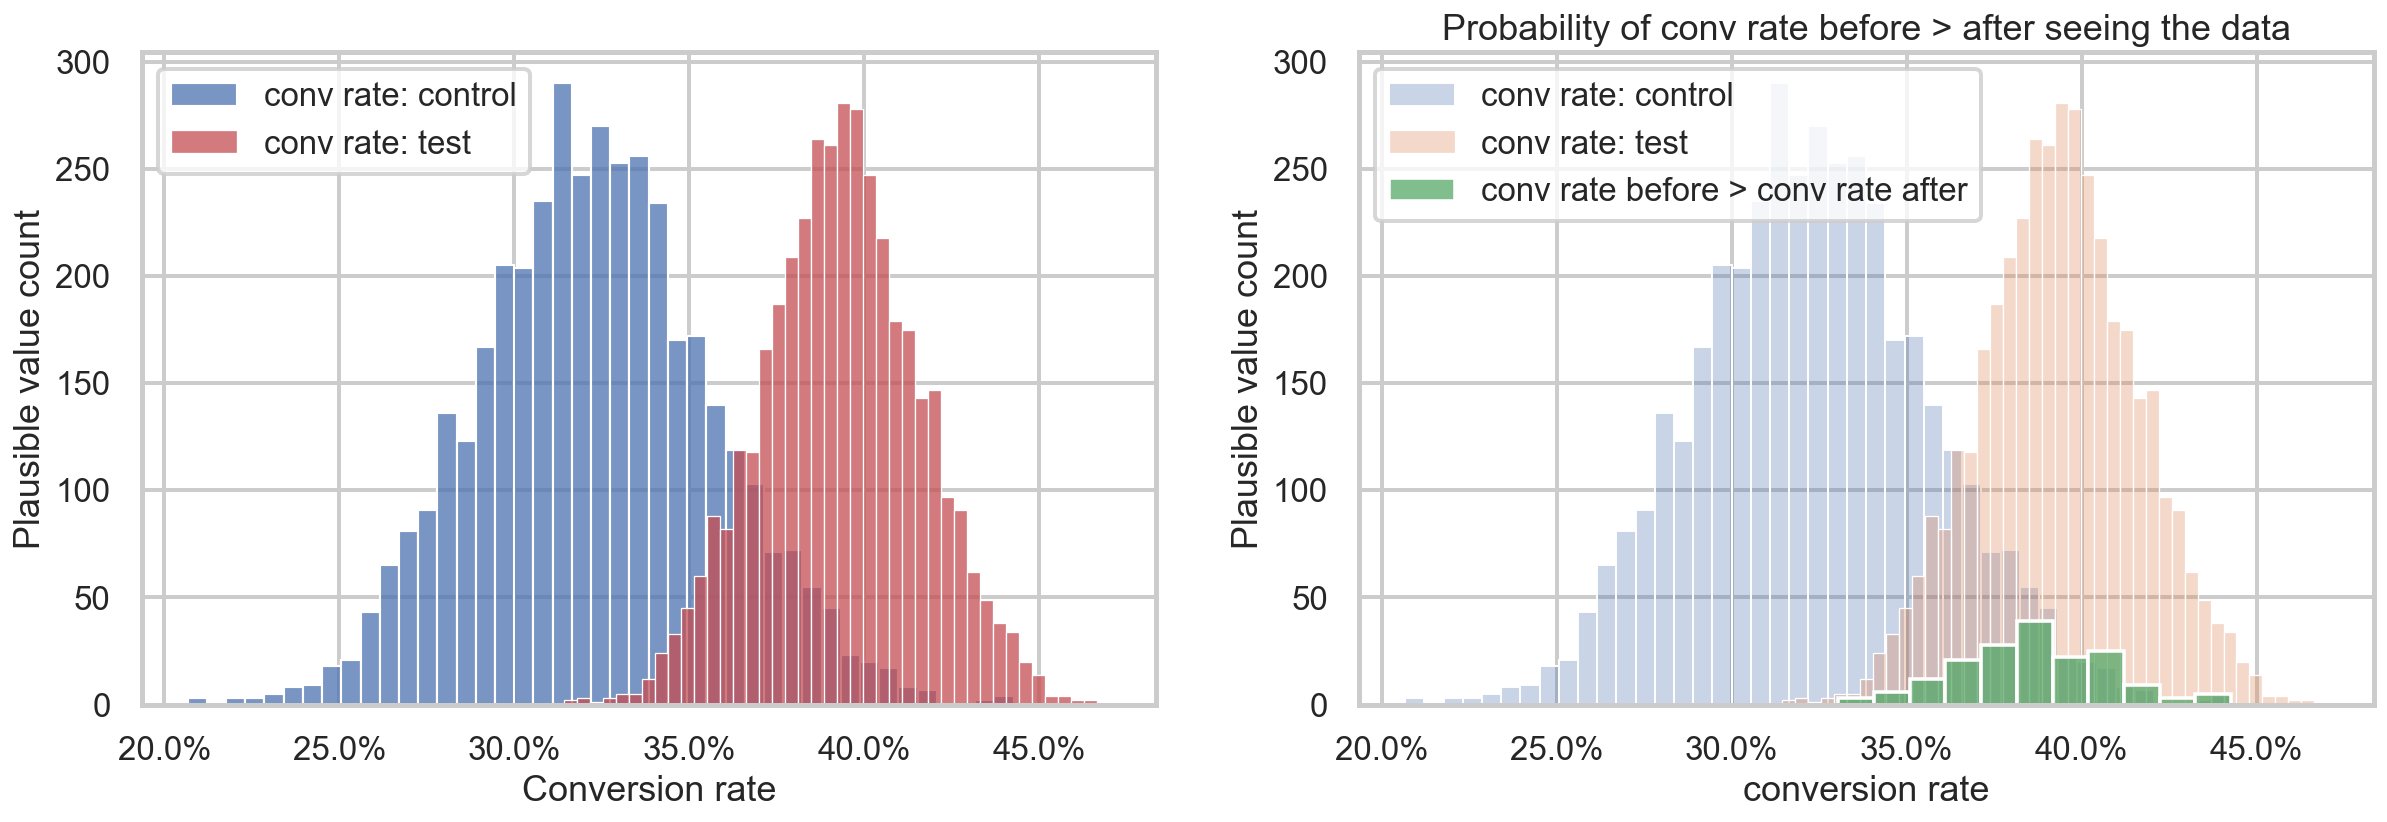

In [18]:
# Using a Bernoulli Likelihood Function
plot_rate_before_after(post_conversion_a, post_conversion_b)

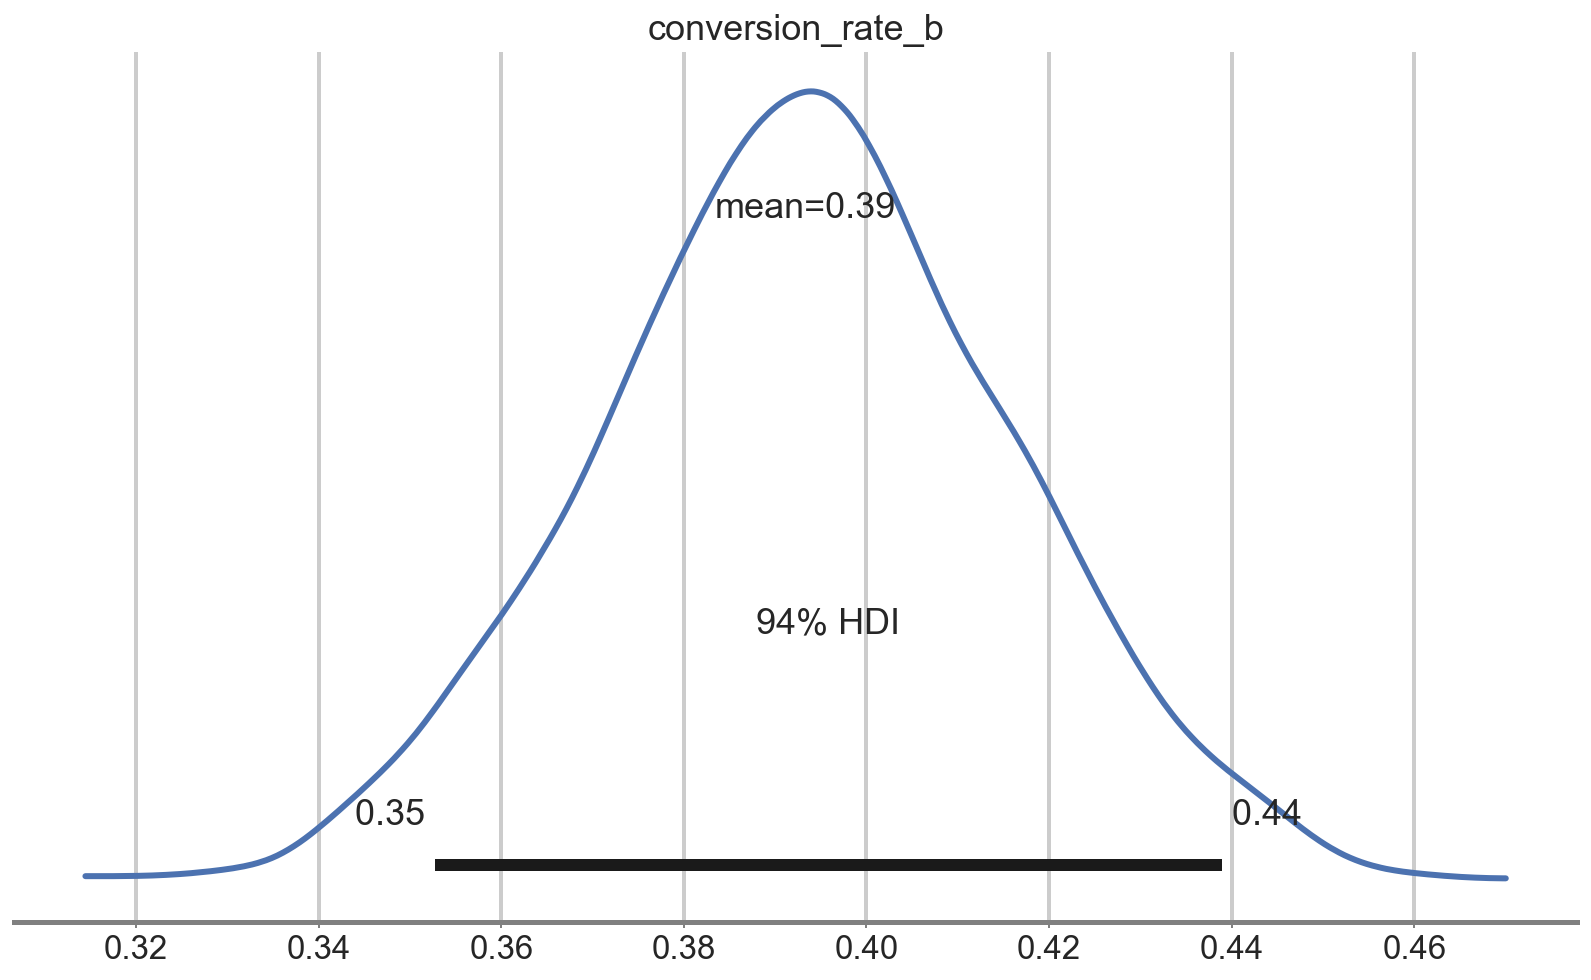

In [19]:
plot_hdi(idata_b)

In [20]:
def hdi_forest_plot(inference_data_a, inference_data_b):
    sns.set_context("poster", font_scale=0.75)
    sns.set_style("whitegrid")
    ax = az.plot_forest(
        [inference_data_a, inference_data_b],
        model_names=["Control Period", "Test Period"],
        combined=True,
        figsize=(14, 5),
        hdi_prob=.95
    )
    ax[0].set_title("Conversion Rate Distribution Plot")
    
    plt.show()

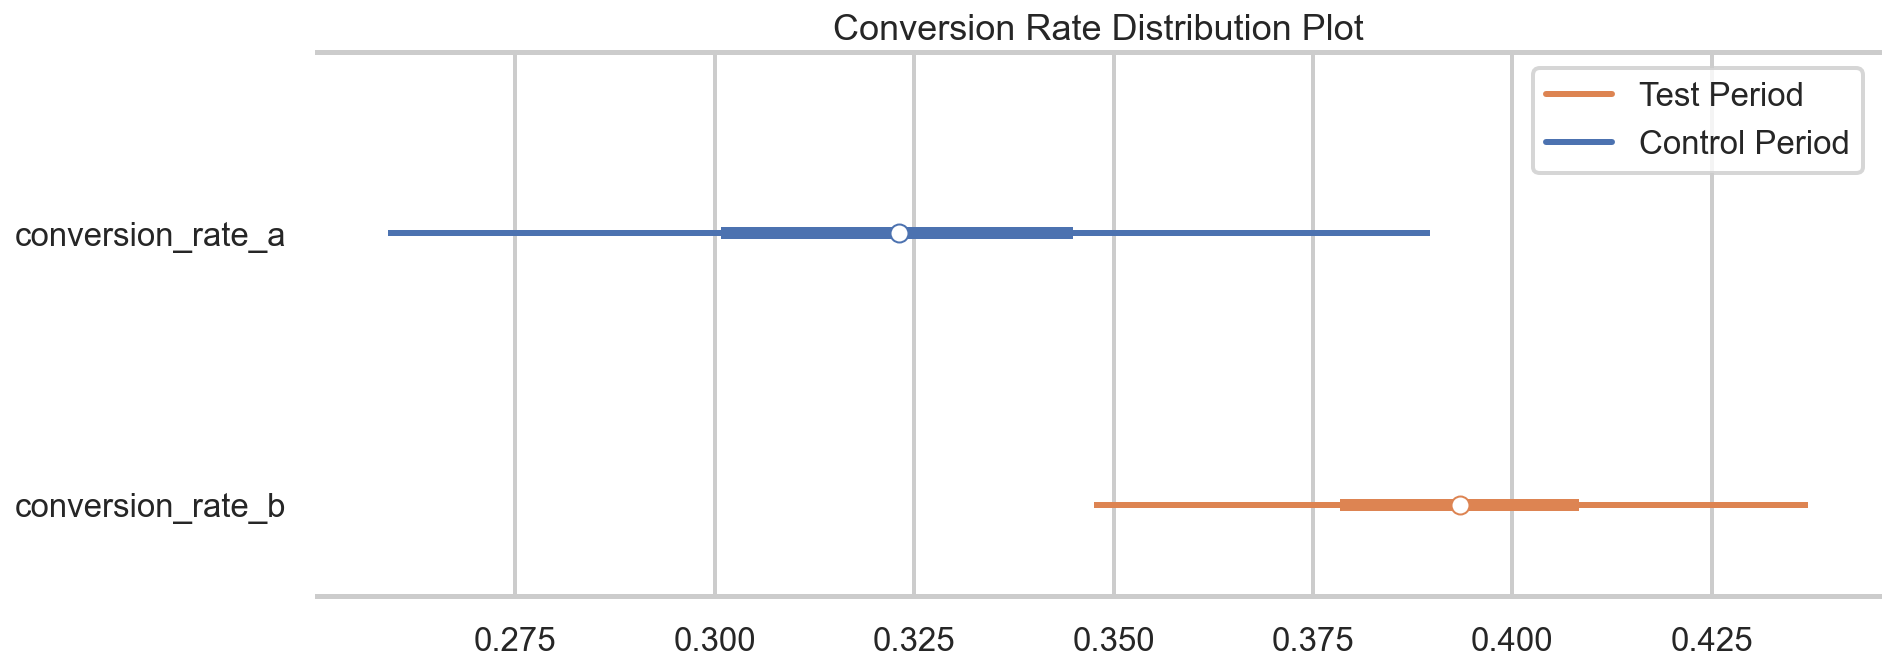

In [21]:
hdi_forest_plot(idata_a, idata_b)

In [26]:
def hdi_forest_distribution_plot(inference_data_a, inference_data_b):
    sns.set_style("whitegrid")
    ax = az.plot_forest(
        [inference_data_a, inference_data_b],
        model_names=["Control Period", "Test Period"],
        combined=True,
        kind="ridgeplot",
        figsize=(14, 5)
    )
    ax[0].set_title("Conversion Rate Distribution Plot")
    plt.show()

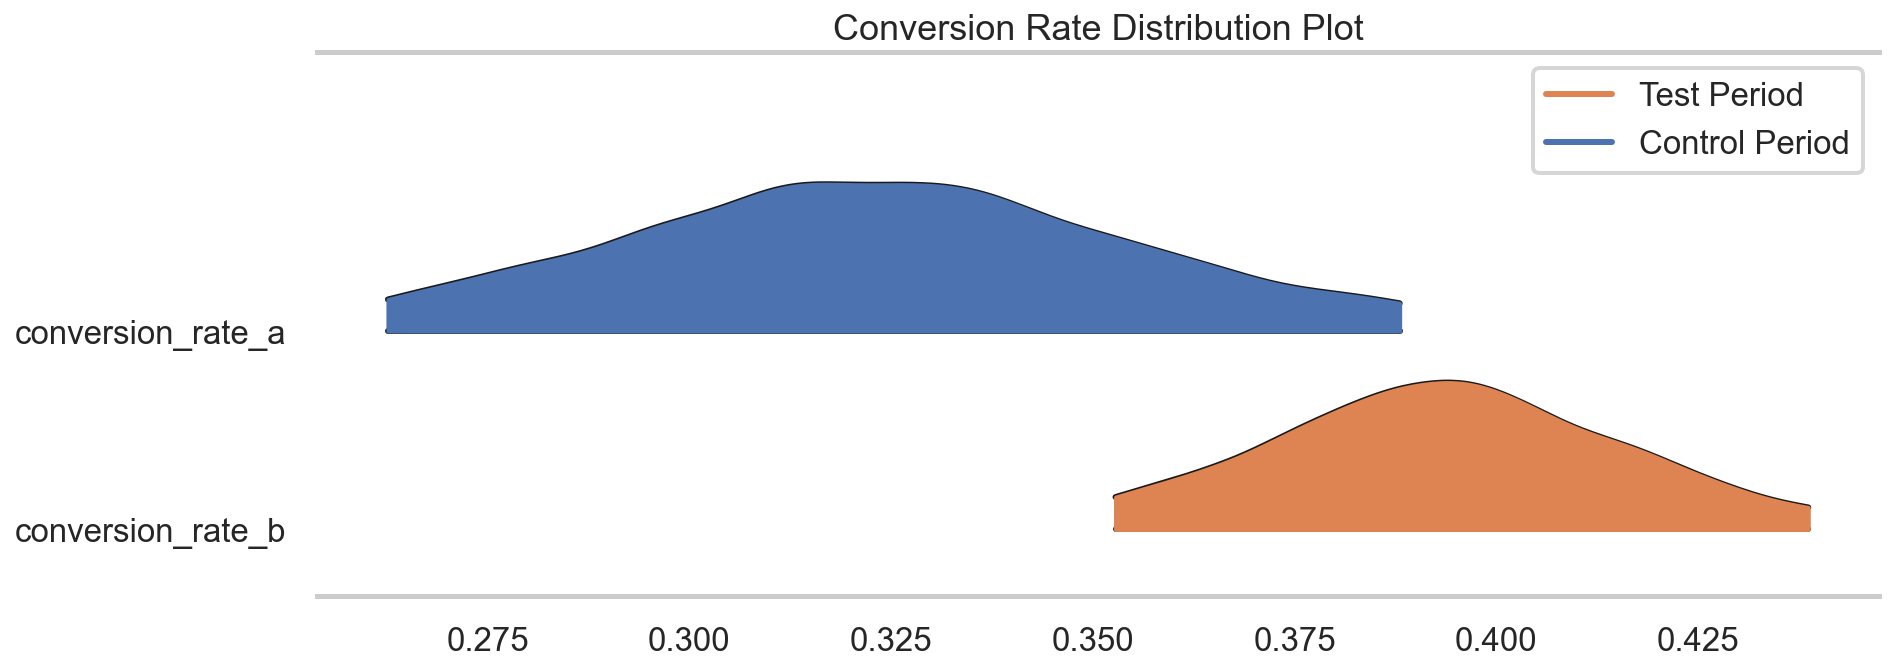

In [27]:
hdi_forest_distribution_plot(idata_a, idata_b)

In [24]:
print("Posterior Mean for Conv Rate in control period: %5.2f%%" % 
      (round(idata_a.posterior.data_vars['conversion_rate_a'].values.mean() * 100.0, 2)))

print("Posterior Mean for Conv Rate in test period : %5.2f%%" % 
      (round(idata_b.posterior.data_vars['conversion_rate_b'].values.mean() * 100.0, 2)))

# Check the probabilty on the conversion distribution a is greater than distribution b
a_lt_b = (post_conversion_a < post_conversion_b)

print("Probability that the treatment has a higher conversion rate than before the treatment was introduced is:", np.mean(a_lt_b))

Posterior Mean for Conv Rate in control period: 32.33%
Posterior Mean for Conv Rate in test period : 39.33%
Probability that the treatment has a higher conversion rate than before the treatment was introduced is: 0.95675


## Business Conclusion

We are fairly certain with 95% probability that since the treatment the conversion rate has increased.

It increased on average 7% which is more than 5% from our alternative hypothesis.  See next notebook for calculation of credible interval of the change under 2_Outlier_AB folder.

What if we performed the frequentist's statistics instead?

## Frequentist Method: Recall the T-Test

See the [formulae for the t-test](https://www.reneshbedre.com/blog/ttest.html#formula-1) and remember the data is assumed to be normally distributed given a large enough sample size.  Bayesian statistics have no such assumptions.

[<img src="image/ttest-diagram.png" width="400"/>](image/ttest-diagram.png)

In [25]:
# Using Frequentist Statistics: one-tail T-test

# Assume the variance of the 2 datasets are equal
#   2-tail test
print(sps.ttest_ind(a=conversion_control, b=conversion_test, equal_var=True, alternative="two-sided"))
#   1-tail test
print(sps.ttest_ind(a=conversion_control, b=conversion_test, equal_var=True, alternative="less"))

# Assume the variance of the 2 datasets are NOT equal
#   2-tail test
print(sps.ttest_ind(a=conversion_control, b=conversion_test, equal_var=False, alternative="two-sided"))
#   1-tail test
print(sps.ttest_ind(a=conversion_control, b=conversion_test, equal_var=False, alternative="less"))

Ttest_indResult(statistic=-1.5025611169222326, pvalue=0.13347488325053342)
Ttest_indResult(statistic=-1.5025611169222326, pvalue=0.06673744162526671)
Ttest_indResult(statistic=-1.5280494601767491, pvalue=0.1275289521446123)
Ttest_indResult(statistic=-1.5280494601767491, pvalue=0.06376447607230615)


### T-Test approach 

In a frequentist approach, we would not reject the null hypothesis (at p-value of 0.05) that the Control mean < Test mean.  

Here, we have p-value of 0.0667 and 0.0637 for equal and non-equal sample size variance assumption respectively.  Then, we need to check if we adhere to all the conditions needed to run the t-test (discused below). 

We can argue whether the arbitarily selected p-value=0.05 is a good choice or not.  If we had selected 0.065 p-value then we'll really have a conundrum on our hands!   But don't p-hack, choose your p-value before your test.  Write it down, show it to your colleague then run your test.

Checking visually using an online app: https://www.evanmiller.org/ab-testing/t-test.html#!0.331325/0.472114/166;0.397727/0.489986/440@95

[<img src="image/ttest-visually.png" width="600"/>](image/ttest-visually.png)

## Conclusion: Two A/B Testing Approaches

### Frequentist
* Variance assumption between the 2 samples (before and after the change)
* Data is assumed to be normally distributed 
    * What if data is not normally distributed?
    * Perform a non-parametric test
* Data values must be independent
* Misinterpret p-value and confidence interval
* Require minimum sample size and power of the test 

More on frequentist statistics: https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/two-sample-t-test.html

### Bayesian

* No assumption in variance or distribution of data
* Need an assumption with choosing a Prior and Likelihood functions based on experience or domain expertise
    * Important but not vital if it's wrong as it will get informed by data
* Statistics in Bayesian is just counting and comparisons
* Easier to make an interpretation

For a more in-depth discussion, check out: https://www.yield.com/lesson/bayesian-testing/